In [58]:
!pip install sqlalchemy
!pip install pymysql
!pip install lightfm

In [1]:
%matplotlib inline

import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sqlalchemy import create_engine
import pymysql
import scipy.sparse as sps

from lightfm.data import Dataset
from lightfm import LightFM
from lightfm.evaluation import auc_score
from lightfm.cross_validation import random_train_test_split

In [2]:
db_connection_str = 'mysql+pymysql://root:123@db/invest'
db_connection = create_engine(db_connection_str)

df_clientes = pd.read_sql('SELECT * FROM cli_Clientes', con=db_connection)
df_cliente_produto = pd.read_sql('SELECT * FROM cli_Produtos', con=db_connection)
df_produtos = pd.read_sql('SELECT * FROM Produtos', con=db_connection)

In [3]:
df_cliente_produto.sample(2)

,userid,produtoid,valorrendimento,dataefetivacao
1232,698,6085,NaN,2019-07-24
30695,2240,6085,NaN,2019-10-08


In [4]:
# removendo linhas com userid = 0 -> esses são os produtos que nenhum cliente comprou ainda

df_cliente_produto = df_cliente_produto[df_cliente_produto['userid'] > 0]

In [5]:
df_cliente_produto.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 48333 entries, 0 to 48332
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   userid           48333 non-null  int64  
 1   produtoid        48333 non-null  int64  
 2   valorrendimento  7216 non-null   float64
 3   dataefetivacao   48272 non-null  object 
dtypes: float64(1), int64(2), object(1)
memory usage: 1.8+ MB


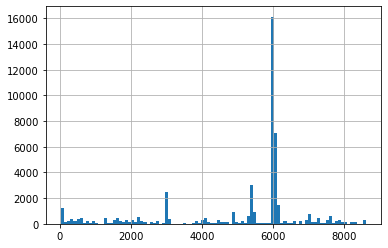

In [6]:
df_cliente_produto['produtoid'].hist(bins = 100)

In [7]:
# analisando os produtos mais populares
df_cliente_produto['produtoid'].value_counts()

5972    15397
6085     4470
5386     3011
6082     2001
6138     1331
        ...  
6106        1
6170        1
134         1
6266        1
5909        1
Name: produtoid, Length: 900, dtype: int64

In [8]:
# o produto mais popular
df_produtos[df_produtos['dataId'] == 5972]

,dataId,AdministradorFundo,AtivoDisponivel,Carencia,CarteiraCNPJ,CNPJAdministrador,DataDeVencimento,DescontoIR,DescricaoAtivo,DescricaoCarencia,...,TipoCarteira,TipoCota,TipoIndexador,TipoRegimeCondomonioCVM,Tributacao,ValorMinimoAplicacaoAdicional,ValorMinimoAplicaInicial,ValorMinimoResgate,ValorMinimo,Vencimento
5972,5972,SANTANDER SECURITIES SERVICES BRASIL DTVM S.A.,1,None,30.353.590/0001-05,03.502.968/0001-04,None,22.5,O FUNDO tem por objetivo investir em ativos fi...,Qualquer dia,...,Fundo de Renda Fixa,Abertura,None,Aberto,Longo prazo,30.0,30.0,30.0,NaN,None


In [9]:
# vendo os clientes que compraram mais vezes o produto mais popular
df_cliente_produto[df_cliente_produto['produtoid'] == 5972]['userid'].value_counts()

1369     36
736      27
462      22
566      21
2353     20
         ..
1076      1
11321     1
3133      1
1092      1
2049      1
Name: userid, Length: 6927, dtype: int64

In [10]:
# removendo os relacionamentos duplicados (clientes que compraram o mesmo produto mais de uma vez)
df_cliente_produto = df_cliente_produto[['userid','produtoid']].drop_duplicates()

In [11]:
df_cliente_produto.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 30061 entries, 0 to 48332
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype
---  ------     --------------  -----
 0   userid     30061 non-null  int64
 1   produtoid  30061 non-null  int64
dtypes: int64(2)
memory usage: 704.6 KB


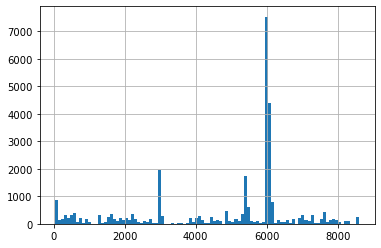

In [12]:
df_cliente_produto['produtoid'].hist(bins = 100)

In [13]:
df_clientes.sample(2)

,userid,userid_aux,idade,genero,estadocivil,billingcity,profissaopessoa,patrimonioautomoveis,patrimonioimoveis,patrimonioinvestimentos,...,nivelconhecimentoatual,scorenivelconhecimento,perfilinvestidor,rendamensal,valorpatrimonio,scorerisco,scoreobjetivos,scoresituacaofinanceira,createddate,dataclienteefetivado
9077,9078,$2b$10$.DCvvJ9WSDpqVP2xXjeSPe1kbwfaHy9ltyccwRJ...,39.3,M,M,Embu das Artes,Bancário e Economiário,0.0,0.0,0.0,...,2.0,2.0,2,2500.0,NaN,2.0,2.0,1.0,2019-01-29 17:35:25,2019-09-30 12:00:00
441,442,$2b$10$.DCvvJ9WSDpqVP2xXjeSPeR8ibChxBJZgFFl5k6...,54.8,M,S,Salvador,Auxiliar de Escritório e Assemelhados,0.0,0.0,0.0,...,5.0,5.0,4,3000.0,NaN,4.0,3.0,4.0,2019-06-28 21:29:13,2019-07-01 12:00:00


In [14]:
df_clientes.describe()

,userid,idade,patrimonioautomoveis,patrimonioimoveis,patrimonioinvestimentos,patrimoniooutros,nivelconhecimentoatual,scorenivelconhecimento,perfilinvestidor,rendamensal,valorpatrimonio,scorerisco,scoreobjetivos,scoresituacaofinanceira
count,14188.000000,14188.000000,13780.000000,13780.000000,13780.000000,13780.000000,13628.000000,14187.000000,14188.000000,1.418800e+04,9.498000e+03,14187.000000,14187.000000,14187.000000
mean,7094.500000,36.841303,2.819303,7.294630,8.126996,0.972424,2.453625,2.467893,2.760290,7.692467e+03,8.407910e+05,2.648411,3.065130,2.100092
std,4095.867145,11.037122,11.308762,20.933896,22.452113,6.901847,1.545563,1.548641,1.083585,2.425389e+04,1.567628e+07,1.105727,1.166216,1.036411
min,1.000000,18.100000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,0.000000e+00,0.000000e+00,1.000000,1.000000,1.000000
25%,3547.750000,28.700000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,2.000000,1.830000e+03,3.000000e+04,2.000000,2.000000,1.000000
50%,7094.500000,35.300000,0.000000,0.000000,0.000000,0.000000,2.000000,2.000000,3.000000,4.000000e+03,1.900000e+05,2.000000,3.000000,2.000000
75%,10641.250000,42.800000,0.000000,0.000000,0.000000,0.000000,4.000000,4.000000,4.000000,9.000000e+03,6.000000e+05,3.000000,4.000000,3.000000
max,14188.000000,96.200000,100.000000,100.000000,100.000000,100.000000,5.000000,5.000000,5.000000,2.400000e+06,1.500000e+09,5.000000,5.000000,5.000000


(array([2.300e+03, 3.872e+03, 4.011e+03, 2.154e+03, 1.050e+03, 5.170e+02,
        2.110e+02, 5.700e+01, 1.300e+01, 3.000e+00]),
 array([18.1 , 25.91, 33.72, 41.53, 49.34, 57.15, 64.96, 72.77, 80.58,
        88.39, 96.2 ]),
 <a list of 10 Patch objects>)

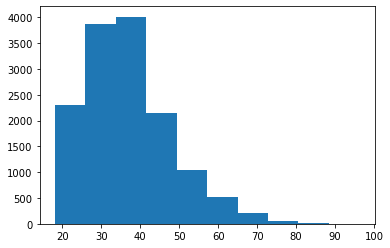

In [15]:
plt.hist(df_clientes['idade'])

In [16]:
df_clientes['idade'] = pd.cut(df_clientes['idade'], bins=[0,20,35,65,100], labels=["jovem", "jovemadulto", "adulto", "idoso"])

(array([6704.,    0.,    0., 6963.,    0.,    0.,  240.,    0.,    0.,
         281.]),
 array([0. , 0.3, 0.6, 0.9, 1.2, 1.5, 1.8, 2.1, 2.4, 2.7, 3. ]),
 <a list of 10 Patch objects>)

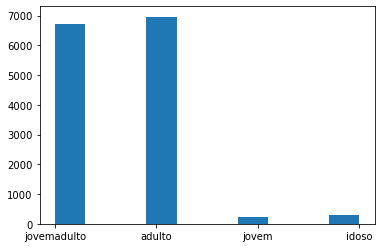

In [17]:
plt.hist(df_clientes['idade'])

In [18]:
df_produtos.sample(2)

,dataId,AdministradorFundo,AtivoDisponivel,Carencia,CarteiraCNPJ,CNPJAdministrador,DataDeVencimento,DescontoIR,DescricaoAtivo,DescricaoCarencia,...,TipoCarteira,TipoCota,TipoIndexador,TipoRegimeCondomonioCVM,Tributacao,ValorMinimoAplicacaoAdicional,ValorMinimoAplicaInicial,ValorMinimoResgate,ValorMinimo,Vencimento
4331,4331,None,0,2025-01-15,None,None,2025-01-15,15.0,"O Certificado de Depxsito Bancxrio, de forma s...",No venc.,...,None,None,IPCA,None,None,NaN,NaN,NaN,1000.0,2025-01-15
6315,6315,None,0,2024-07-02,None,None,2024-07-02,15.0,"O Certificado de Depósito Bancário, de forma s...",No venc.,...,None,None,Pré fixado,None,None,NaN,NaN,NaN,5000.0,2024-07-02


In [21]:
# selecionando as features do dataset de clientes a serem utilizadas
df_clientes_features = df_clientes[['userid', 'idade', 'perfilinvestidor', 'scoresituacaofinanceira', 'scorenivelconhecimento']]
df_clientes_features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14188 entries, 0 to 14187
Data columns (total 5 columns):
 #   Column                   Non-Null Count  Dtype   
---  ------                   --------------  -----   
 0   userid                   14188 non-null  int64   
 1   idade                    14188 non-null  category
 2   perfilinvestidor         14188 non-null  int64   
 3   scoresituacaofinanceira  14187 non-null  float64 
 4   scorenivelconhecimento   14187 non-null  float64 
dtypes: category(1), float64(2), int64(2)
memory usage: 457.5 KB


In [22]:
df_clientes_features.loc[:, 'perfilinvestidor'] = 'perfil' + df_clientes_features['perfilinvestidor'].map(str)
df_clientes_features.loc[:, 'scoresituacaofinanceira'] = 'scoresf' + df_clientes_features['scoresituacaofinanceira'].map(str)
df_clientes_features.loc[:, 'scorenivelconhecimento'] = 'scorenc' + df_clientes_features['scorenivelconhecimento'].map(str)
df_clientes_features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14188 entries, 0 to 14187
Data columns (total 5 columns):
 #   Column                   Non-Null Count  Dtype   
---  ------                   --------------  -----   
 0   userid                   14188 non-null  int64   
 1   idade                    14188 non-null  category
 2   perfilinvestidor         14188 non-null  object  
 3   scoresituacaofinanceira  14188 non-null  object  
 4   scorenivelconhecimento   14188 non-null  object  
dtypes: category(1), int64(1), object(3)
memory usage: 457.5+ KB


In [23]:
df_clientes_features

,userid,idade,perfilinvestidor,scoresituacaofinanceira,scorenivelconhecimento
0,1,jovemadulto,perfil4,scoresf4.0,scorenc2.0
1,2,jovemadulto,perfil2,scoresf2.0,scorenc1.0
2,3,adulto,perfil1,scoresf1.0,scorenc2.0
3,4,adulto,perfil3,scoresf2.0,scorenc4.0
4,5,jovemadulto,perfil2,scoresf2.0,scorenc1.0
...,...,...,...,...,...
14183,14184,jovemadulto,perfil2,scoresf4.0,scorenc2.0
14184,14185,jovemadulto,perfil2,scoresf3.0,scorenc1.0
14185,14186,adulto,perfil2,scoresf1.0,scorenc1.0
14186,14187,jovemadulto,perfil2,scoresf2.0,scorenc3.0


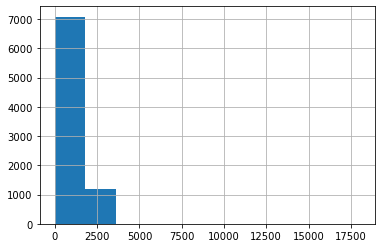

In [28]:
df_produtos['PrazoDias'].hist(bins = 10)

In [29]:
df_produtos['PrazoDias'] = pd.cut(df_produtos['PrazoDias'], bins=[0,731,1250,4000], labels=["curtoPrazo", "medioPrazo", "longoPrazo"])

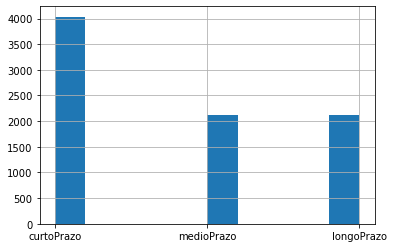

In [30]:
df_produtos['PrazoDias'].hist()

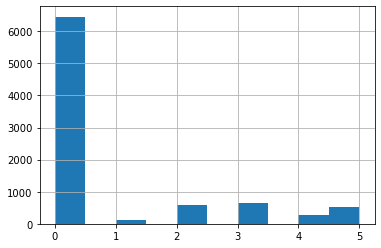

In [31]:
df_produtos['RiscoAtivo'].hist()

In [32]:
df_produtos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8603 entries, 0 to 8602
Data columns (total 86 columns):
 #   Column                             Non-Null Count  Dtype   
---  ------                             --------------  -----   
 0   dataId                             8603 non-null   int64   
 1   AdministradorFundo                 320 non-null    object  
 2   AtivoDisponivel                    8603 non-null   int64   
 3   Carencia                           8282 non-null   object  
 4   CarteiraCNPJ                       320 non-null    object  
 5   CNPJAdministrador                  320 non-null    object  
 6   DataDeVencimento                   8282 non-null   object  
 7   DescontoIR                         8603 non-null   float64 
 8   DescricaoAtivo                     8593 non-null   object  
 9   DescricaoCarencia                  8603 non-null   object  
 10  DescricaoClasse                    8282 non-null   object  
 11  DescricaoCotizacaoAplicacao        8603 non

In [35]:
# selecionando as features do dataset de produtos a serem utilizadas
df_produtos_features = df_produtos[['dataId', 
                                    'PrazoDias', 
                                    'ResgateDias', 
                                    'RiscoAtivo', 
                                    'SeFGCAtivo', 
                                    'DescricaoTributacao',
                                    'DescricaoLiquidacaoResgate']]
df_produtos_features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8603 entries, 0 to 8602
Data columns (total 7 columns):
 #   Column                      Non-Null Count  Dtype   
---  ------                      --------------  -----   
 0   dataId                      8603 non-null   int64   
 1   PrazoDias                   8278 non-null   category
 2   ResgateDias                 8603 non-null   object  
 3   RiscoAtivo                  8602 non-null   float64 
 4   SeFGCAtivo                  8603 non-null   int64   
 5   DescricaoTributacao         8603 non-null   object  
 6   DescricaoLiquidacaoResgate  8603 non-null   object  
dtypes: category(1), float64(1), int64(2), object(3)
memory usage: 411.9+ KB


In [36]:
df_produtos_features.loc[:,'PrazoDias'] = df_produtos_features['PrazoDias'].fillna('curtoPrazo')
df_produtos_features.loc[:,'RiscoAtivo'] = df_produtos_features['RiscoAtivo'].fillna('0')
df_produtos_features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8603 entries, 0 to 8602
Data columns (total 7 columns):
 #   Column                      Non-Null Count  Dtype   
---  ------                      --------------  -----   
 0   dataId                      8603 non-null   int64   
 1   PrazoDias                   8603 non-null   category
 2   ResgateDias                 8603 non-null   object  
 3   RiscoAtivo                  8603 non-null   object  
 4   SeFGCAtivo                  8603 non-null   int64   
 5   DescricaoTributacao         8603 non-null   object  
 6   DescricaoLiquidacaoResgate  8603 non-null   object  
dtypes: category(1), int64(2), object(4)
memory usage: 411.9+ KB


In [37]:
df_produtos_features.loc[:, 'RiscoAtivo'] = 'Risco' + df_produtos_features['RiscoAtivo'].map(str)
df_produtos_features.loc[:, 'SeFGCAtivo'] = 'FGCAtivo' + df_produtos_features['SeFGCAtivo'].map(str)
df_produtos_features

,dataId,PrazoDias,ResgateDias,RiscoAtivo,SeFGCAtivo,DescricaoTributacao,DescricaoLiquidacaoResgate
0,0,curtoPrazo,No venc.,Risco0.0,FGCAtivo1,15%,No dia
1,1,medioPrazo,No venc.,Risco0.0,FGCAtivo1,15%,No dia
2,2,medioPrazo,No venc.,Risco0.0,FGCAtivo1,15%,No dia
3,3,longoPrazo,No venc.,Risco0.0,FGCAtivo1,15%,No dia
4,4,curtoPrazo,No venc.,Risco0.0,FGCAtivo1,15%,No dia
...,...,...,...,...,...,...,...
8598,8598,curtoPrazo,No venc.,Risco0.0,FGCAtivo1,15%,No dia
8599,8599,medioPrazo,No venc.,Risco0.0,FGCAtivo1,15%,No dia
8600,8600,longoPrazo,No venc.,Risco0.0,FGCAtivo1,15%,No dia
8601,8601,longoPrazo,No venc.,Risco5.0,FGCAtivo1,15%,No dia


In [38]:
dataset = Dataset(user_identity_features=False, 
                  item_identity_features=False)
dataset.fit((x for x in df_clientes['userid'].unique()),
            (x for x in df_produtos['dataId'].unique()), 
            user_features=df_clientes_features.drop('userid', axis=1).values.ravel(),
            item_features=df_produtos_features.drop('dataId', axis=1).values.ravel())

In [39]:
num_users, num_items = dataset.interactions_shape()
print('Num users: {}, num_items {}.'.format(num_users, num_items))

Num users: 14188, num_items 8603.


In [40]:
# Construindo a matriz de interações
(interactions, weights) = dataset.build_interactions(((x[0], x[1]) for x in df_cliente_produto.values))

print(repr(interactions))

<14188x8603 sparse matrix of type '<class 'numpy.int32'>'
	with 30061 stored elements in COOrdinate format>


In [41]:
user_features = dataset.build_user_features(((x[0], [x[1], x[2], x[3], x[4]])
                                              for x in df_clientes_features.values))
print(repr(user_features))

<14188x21 sparse matrix of type '<class 'numpy.float32'>'
	with 56752 stored elements in Compressed Sparse Row format>


In [42]:
item_features = dataset.build_item_features(((x[0], [x[1], x[2], x[3], x[4], x[5], x[6]])
                                              for x in df_produtos_features.values))
print(repr(item_features))

<8603x23 sparse matrix of type '<class 'numpy.float32'>'
	with 51618 stored elements in Compressed Sparse Row format>


In [43]:
user_id_map, user_feature_map, item_id_map, item_feature_map = dataset.mapping()

In [44]:
user_feature_map

{'jovemadulto': 0,
 'perfil4': 1,
 'scoresf4.0': 2,
 'scorenc2.0': 3,
 'perfil2': 4,
 'scoresf2.0': 5,
 'scorenc1.0': 6,
 'adulto': 7,
 'perfil1': 8,
 'scoresf1.0': 9,
 'perfil3': 10,
 'scorenc4.0': 11,
 'scoresf3.0': 12,
 'scorenc5.0': 13,
 'scorenc3.0': 14,
 'perfil5': 15,
 'jovem': 16,
 'idoso': 17,
 'scoresf5.0': 18,
 'scoresfnan': 19,
 'scorencnan': 20}

In [45]:
item_feature_map

{'curtoPrazo': 0,
 'No venc.': 1,
 'Risco0.0': 2,
 'FGCAtivo1': 3,
 '15%': 4,
 'No dia': 5,
 'medioPrazo': 6,
 'longoPrazo': 7,
 'Risco3.0': 8,
 'Qualquer dia': 9,
 'Risco5.0': 10,
 'FGCAtivo0': 11,
 '2 Dias úteis': 12,
 'Risco2.0': 13,
 'Risco4.0': 14,
 'Risco1.0': 15,
 'Come Cotas': 16,
 '1 Dia útil': 17,
 '5 Dias úteis': 18,
 '3 Dias úteis': 19,
 'Com carência': 20,
 'Risco0': 21,
 '4 Dias úteis': 22}

In [46]:
# dividindo o dataset em treino e teste

interactions_train, interactions_test = random_train_test_split(
    interactions, 
    test_percentage=0.2, 
    random_state=np.random.RandomState(2020)
)

In [49]:
# treinando o modelo
model = LightFM(
    no_components=10,
    learning_rate=0.05,
    loss='warp',
    random_state=2019)

model = model.fit(interactions_train,
                  user_features=user_features,
                  epochs=10000,
                  num_threads=16, verbose=True)

Epoch 0
Epoch 1
Epoch 2
Epoch 3
Epoch 4
Epoch 5
Epoch 6
Epoch 7
Epoch 8
Epoch 9
Epoch 10
Epoch 11
Epoch 12
Epoch 13
Epoch 14
Epoch 15
Epoch 16
Epoch 17
Epoch 18
Epoch 19
Epoch 20
Epoch 21
Epoch 22
Epoch 23
Epoch 24
Epoch 25
Epoch 26
Epoch 27
Epoch 28
Epoch 29
Epoch 30
Epoch 31
Epoch 32
Epoch 33
Epoch 34
Epoch 35
Epoch 36
Epoch 37
Epoch 38
Epoch 39
Epoch 40
Epoch 41
Epoch 42
Epoch 43
Epoch 44
Epoch 45
Epoch 46
Epoch 47
Epoch 48
Epoch 49
Epoch 50
Epoch 51
Epoch 52
Epoch 53
Epoch 54
Epoch 55
Epoch 56
Epoch 57
Epoch 58
Epoch 59
Epoch 60
Epoch 61
Epoch 62
Epoch 63
Epoch 64
Epoch 65
Epoch 66
Epoch 67
Epoch 68
Epoch 69
Epoch 70
Epoch 71
Epoch 72
Epoch 73
Epoch 74
Epoch 75
Epoch 76
Epoch 77
Epoch 78
Epoch 79
Epoch 80
Epoch 81
Epoch 82
Epoch 83
Epoch 84
Epoch 85
Epoch 86
Epoch 87
Epoch 88
Epoch 89
Epoch 90
Epoch 91
Epoch 92
Epoch 93
Epoch 94
Epoch 95
Epoch 96
Epoch 97
Epoch 98
Epoch 99
Epoch 100
Epoch 101
Epoch 102
Epoch 103
Epoch 104
Epoch 105
Epoch 106
Epoch 107
Epoch 108
Epoch 109
Epoch 110


Epoch 839
Epoch 840
Epoch 841
Epoch 842
Epoch 843
Epoch 844
Epoch 845
Epoch 846
Epoch 847
Epoch 848
Epoch 849
Epoch 850
Epoch 851
Epoch 852
Epoch 853
Epoch 854
Epoch 855
Epoch 856
Epoch 857
Epoch 858
Epoch 859
Epoch 860
Epoch 861
Epoch 862
Epoch 863
Epoch 864
Epoch 865
Epoch 866
Epoch 867
Epoch 868
Epoch 869
Epoch 870
Epoch 871
Epoch 872
Epoch 873
Epoch 874
Epoch 875
Epoch 876
Epoch 877
Epoch 878
Epoch 879
Epoch 880
Epoch 881
Epoch 882
Epoch 883
Epoch 884
Epoch 885
Epoch 886
Epoch 887
Epoch 888
Epoch 889
Epoch 890
Epoch 891
Epoch 892
Epoch 893
Epoch 894
Epoch 895
Epoch 896
Epoch 897
Epoch 898
Epoch 899
Epoch 900
Epoch 901
Epoch 902
Epoch 903
Epoch 904
Epoch 905
Epoch 906
Epoch 907
Epoch 908
Epoch 909
Epoch 910
Epoch 911
Epoch 912
Epoch 913
Epoch 914
Epoch 915
Epoch 916
Epoch 917
Epoch 918
Epoch 919
Epoch 920
Epoch 921
Epoch 922
Epoch 923
Epoch 924
Epoch 925
Epoch 926
Epoch 927
Epoch 928
Epoch 929
Epoch 930
Epoch 931
Epoch 932
Epoch 933
Epoch 934
Epoch 935
Epoch 936
Epoch 937
Epoch 938


Epoch 1603
Epoch 1604
Epoch 1605
Epoch 1606
Epoch 1607
Epoch 1608
Epoch 1609
Epoch 1610
Epoch 1611
Epoch 1612
Epoch 1613
Epoch 1614
Epoch 1615
Epoch 1616
Epoch 1617
Epoch 1618
Epoch 1619
Epoch 1620
Epoch 1621
Epoch 1622
Epoch 1623
Epoch 1624
Epoch 1625
Epoch 1626
Epoch 1627
Epoch 1628
Epoch 1629
Epoch 1630
Epoch 1631
Epoch 1632
Epoch 1633
Epoch 1634
Epoch 1635
Epoch 1636
Epoch 1637
Epoch 1638
Epoch 1639
Epoch 1640
Epoch 1641
Epoch 1642
Epoch 1643
Epoch 1644
Epoch 1645
Epoch 1646
Epoch 1647
Epoch 1648
Epoch 1649
Epoch 1650
Epoch 1651
Epoch 1652
Epoch 1653
Epoch 1654
Epoch 1655
Epoch 1656
Epoch 1657
Epoch 1658
Epoch 1659
Epoch 1660
Epoch 1661
Epoch 1662
Epoch 1663
Epoch 1664
Epoch 1665
Epoch 1666
Epoch 1667
Epoch 1668
Epoch 1669
Epoch 1670
Epoch 1671
Epoch 1672
Epoch 1673
Epoch 1674
Epoch 1675
Epoch 1676
Epoch 1677
Epoch 1678
Epoch 1679
Epoch 1680
Epoch 1681
Epoch 1682
Epoch 1683
Epoch 1684
Epoch 1685
Epoch 1686
Epoch 1687
Epoch 1688
Epoch 1689
Epoch 1690
Epoch 1691
Epoch 1692
Epoch 1693

Epoch 2355
Epoch 2356
Epoch 2357
Epoch 2358
Epoch 2359
Epoch 2360
Epoch 2361
Epoch 2362
Epoch 2363
Epoch 2364
Epoch 2365
Epoch 2366
Epoch 2367
Epoch 2368
Epoch 2369
Epoch 2370
Epoch 2371
Epoch 2372
Epoch 2373
Epoch 2374
Epoch 2375
Epoch 2376
Epoch 2377
Epoch 2378
Epoch 2379
Epoch 2380
Epoch 2381
Epoch 2382
Epoch 2383
Epoch 2384
Epoch 2385
Epoch 2386
Epoch 2387
Epoch 2388
Epoch 2389
Epoch 2390
Epoch 2391
Epoch 2392
Epoch 2393
Epoch 2394
Epoch 2395
Epoch 2396
Epoch 2397
Epoch 2398
Epoch 2399
Epoch 2400
Epoch 2401
Epoch 2402
Epoch 2403
Epoch 2404
Epoch 2405
Epoch 2406
Epoch 2407
Epoch 2408
Epoch 2409
Epoch 2410
Epoch 2411
Epoch 2412
Epoch 2413
Epoch 2414
Epoch 2415
Epoch 2416
Epoch 2417
Epoch 2418
Epoch 2419
Epoch 2420
Epoch 2421
Epoch 2422
Epoch 2423
Epoch 2424
Epoch 2425
Epoch 2426
Epoch 2427
Epoch 2428
Epoch 2429
Epoch 2430
Epoch 2431
Epoch 2432
Epoch 2433
Epoch 2434
Epoch 2435
Epoch 2436
Epoch 2437
Epoch 2438
Epoch 2439
Epoch 2440
Epoch 2441
Epoch 2442
Epoch 2443
Epoch 2444
Epoch 2445

Epoch 3113
Epoch 3114
Epoch 3115
Epoch 3116
Epoch 3117
Epoch 3118
Epoch 3119
Epoch 3120
Epoch 3121
Epoch 3122
Epoch 3123
Epoch 3124
Epoch 3125
Epoch 3126
Epoch 3127
Epoch 3128
Epoch 3129
Epoch 3130
Epoch 3131
Epoch 3132
Epoch 3133
Epoch 3134
Epoch 3135
Epoch 3136
Epoch 3137
Epoch 3138
Epoch 3139
Epoch 3140
Epoch 3141
Epoch 3142
Epoch 3143
Epoch 3144
Epoch 3145
Epoch 3146
Epoch 3147
Epoch 3148
Epoch 3149
Epoch 3150
Epoch 3151
Epoch 3152
Epoch 3153
Epoch 3154
Epoch 3155
Epoch 3156
Epoch 3157
Epoch 3158
Epoch 3159
Epoch 3160
Epoch 3161
Epoch 3162
Epoch 3163
Epoch 3164
Epoch 3165
Epoch 3166
Epoch 3167
Epoch 3168
Epoch 3169
Epoch 3170
Epoch 3171
Epoch 3172
Epoch 3173
Epoch 3174
Epoch 3175
Epoch 3176
Epoch 3177
Epoch 3178
Epoch 3179
Epoch 3180
Epoch 3181
Epoch 3182
Epoch 3183
Epoch 3184
Epoch 3185
Epoch 3186
Epoch 3187
Epoch 3188
Epoch 3189
Epoch 3190
Epoch 3191
Epoch 3192
Epoch 3193
Epoch 3194
Epoch 3195
Epoch 3196
Epoch 3197
Epoch 3198
Epoch 3199
Epoch 3200
Epoch 3201
Epoch 3202
Epoch 3203

Epoch 3873
Epoch 3874
Epoch 3875
Epoch 3876
Epoch 3877
Epoch 3878
Epoch 3879
Epoch 3880
Epoch 3881
Epoch 3882
Epoch 3883
Epoch 3884
Epoch 3885
Epoch 3886
Epoch 3887
Epoch 3888
Epoch 3889
Epoch 3890
Epoch 3891
Epoch 3892
Epoch 3893
Epoch 3894
Epoch 3895
Epoch 3896
Epoch 3897
Epoch 3898
Epoch 3899
Epoch 3900
Epoch 3901
Epoch 3902
Epoch 3903
Epoch 3904
Epoch 3905
Epoch 3906
Epoch 3907
Epoch 3908
Epoch 3909
Epoch 3910
Epoch 3911
Epoch 3912
Epoch 3913
Epoch 3914
Epoch 3915
Epoch 3916
Epoch 3917
Epoch 3918
Epoch 3919
Epoch 3920
Epoch 3921
Epoch 3922
Epoch 3923
Epoch 3924
Epoch 3925
Epoch 3926
Epoch 3927
Epoch 3928
Epoch 3929
Epoch 3930
Epoch 3931
Epoch 3932
Epoch 3933
Epoch 3934
Epoch 3935
Epoch 3936
Epoch 3937
Epoch 3938
Epoch 3939
Epoch 3940
Epoch 3941
Epoch 3942
Epoch 3943
Epoch 3944
Epoch 3945
Epoch 3946
Epoch 3947
Epoch 3948
Epoch 3949
Epoch 3950
Epoch 3951
Epoch 3952
Epoch 3953
Epoch 3954
Epoch 3955
Epoch 3956
Epoch 3957
Epoch 3958
Epoch 3959
Epoch 3960
Epoch 3961
Epoch 3962
Epoch 3963

Epoch 4626
Epoch 4627
Epoch 4628
Epoch 4629
Epoch 4630
Epoch 4631
Epoch 4632
Epoch 4633
Epoch 4634
Epoch 4635
Epoch 4636
Epoch 4637
Epoch 4638
Epoch 4639
Epoch 4640
Epoch 4641
Epoch 4642
Epoch 4643
Epoch 4644
Epoch 4645
Epoch 4646
Epoch 4647
Epoch 4648
Epoch 4649
Epoch 4650
Epoch 4651
Epoch 4652
Epoch 4653
Epoch 4654
Epoch 4655
Epoch 4656
Epoch 4657
Epoch 4658
Epoch 4659
Epoch 4660
Epoch 4661
Epoch 4662
Epoch 4663
Epoch 4664
Epoch 4665
Epoch 4666
Epoch 4667
Epoch 4668
Epoch 4669
Epoch 4670
Epoch 4671
Epoch 4672
Epoch 4673
Epoch 4674
Epoch 4675
Epoch 4676
Epoch 4677
Epoch 4678
Epoch 4679
Epoch 4680
Epoch 4681
Epoch 4682
Epoch 4683
Epoch 4684
Epoch 4685
Epoch 4686
Epoch 4687
Epoch 4688
Epoch 4689
Epoch 4690
Epoch 4691
Epoch 4692
Epoch 4693
Epoch 4694
Epoch 4695
Epoch 4696
Epoch 4697
Epoch 4698
Epoch 4699
Epoch 4700
Epoch 4701
Epoch 4702
Epoch 4703
Epoch 4704
Epoch 4705
Epoch 4706
Epoch 4707
Epoch 4708
Epoch 4709
Epoch 4710
Epoch 4711
Epoch 4712
Epoch 4713
Epoch 4714
Epoch 4715
Epoch 4716

Epoch 5389
Epoch 5390
Epoch 5391
Epoch 5392
Epoch 5393
Epoch 5394
Epoch 5395
Epoch 5396
Epoch 5397
Epoch 5398
Epoch 5399
Epoch 5400
Epoch 5401
Epoch 5402
Epoch 5403
Epoch 5404
Epoch 5405
Epoch 5406
Epoch 5407
Epoch 5408
Epoch 5409
Epoch 5410
Epoch 5411
Epoch 5412
Epoch 5413
Epoch 5414
Epoch 5415
Epoch 5416
Epoch 5417
Epoch 5418
Epoch 5419
Epoch 5420
Epoch 5421
Epoch 5422
Epoch 5423
Epoch 5424
Epoch 5425
Epoch 5426
Epoch 5427
Epoch 5428
Epoch 5429
Epoch 5430
Epoch 5431
Epoch 5432
Epoch 5433
Epoch 5434
Epoch 5435
Epoch 5436
Epoch 5437
Epoch 5438
Epoch 5439
Epoch 5440
Epoch 5441
Epoch 5442
Epoch 5443
Epoch 5444
Epoch 5445
Epoch 5446
Epoch 5447
Epoch 5448
Epoch 5449
Epoch 5450
Epoch 5451
Epoch 5452
Epoch 5453
Epoch 5454
Epoch 5455
Epoch 5456
Epoch 5457
Epoch 5458
Epoch 5459
Epoch 5460
Epoch 5461
Epoch 5462
Epoch 5463
Epoch 5464
Epoch 5465
Epoch 5466
Epoch 5467
Epoch 5468
Epoch 5469
Epoch 5470
Epoch 5471
Epoch 5472
Epoch 5473
Epoch 5474
Epoch 5475
Epoch 5476
Epoch 5477
Epoch 5478
Epoch 5479

Epoch 6143
Epoch 6144
Epoch 6145
Epoch 6146
Epoch 6147
Epoch 6148
Epoch 6149
Epoch 6150
Epoch 6151
Epoch 6152
Epoch 6153
Epoch 6154
Epoch 6155
Epoch 6156
Epoch 6157
Epoch 6158
Epoch 6159
Epoch 6160
Epoch 6161
Epoch 6162
Epoch 6163
Epoch 6164
Epoch 6165
Epoch 6166
Epoch 6167
Epoch 6168
Epoch 6169
Epoch 6170
Epoch 6171
Epoch 6172
Epoch 6173
Epoch 6174
Epoch 6175
Epoch 6176
Epoch 6177
Epoch 6178
Epoch 6179
Epoch 6180
Epoch 6181
Epoch 6182
Epoch 6183
Epoch 6184
Epoch 6185
Epoch 6186
Epoch 6187
Epoch 6188
Epoch 6189
Epoch 6190
Epoch 6191
Epoch 6192
Epoch 6193
Epoch 6194
Epoch 6195
Epoch 6196
Epoch 6197
Epoch 6198
Epoch 6199
Epoch 6200
Epoch 6201
Epoch 6202
Epoch 6203
Epoch 6204
Epoch 6205
Epoch 6206
Epoch 6207
Epoch 6208
Epoch 6209
Epoch 6210
Epoch 6211
Epoch 6212
Epoch 6213
Epoch 6214
Epoch 6215
Epoch 6216
Epoch 6217
Epoch 6218
Epoch 6219
Epoch 6220
Epoch 6221
Epoch 6222
Epoch 6223
Epoch 6224
Epoch 6225
Epoch 6226
Epoch 6227
Epoch 6228
Epoch 6229
Epoch 6230
Epoch 6231
Epoch 6232
Epoch 6233

Epoch 6907
Epoch 6908
Epoch 6909
Epoch 6910
Epoch 6911
Epoch 6912
Epoch 6913
Epoch 6914
Epoch 6915
Epoch 6916
Epoch 6917
Epoch 6918
Epoch 6919
Epoch 6920
Epoch 6921
Epoch 6922
Epoch 6923
Epoch 6924
Epoch 6925
Epoch 6926
Epoch 6927
Epoch 6928
Epoch 6929
Epoch 6930
Epoch 6931
Epoch 6932
Epoch 6933
Epoch 6934
Epoch 6935
Epoch 6936
Epoch 6937
Epoch 6938
Epoch 6939
Epoch 6940
Epoch 6941
Epoch 6942
Epoch 6943
Epoch 6944
Epoch 6945
Epoch 6946
Epoch 6947
Epoch 6948
Epoch 6949
Epoch 6950
Epoch 6951
Epoch 6952
Epoch 6953
Epoch 6954
Epoch 6955
Epoch 6956
Epoch 6957
Epoch 6958
Epoch 6959
Epoch 6960
Epoch 6961
Epoch 6962
Epoch 6963
Epoch 6964
Epoch 6965
Epoch 6966
Epoch 6967
Epoch 6968
Epoch 6969
Epoch 6970
Epoch 6971
Epoch 6972
Epoch 6973
Epoch 6974
Epoch 6975
Epoch 6976
Epoch 6977
Epoch 6978
Epoch 6979
Epoch 6980
Epoch 6981
Epoch 6982
Epoch 6983
Epoch 6984
Epoch 6985
Epoch 6986
Epoch 6987
Epoch 6988
Epoch 6989
Epoch 6990
Epoch 6991
Epoch 6992
Epoch 6993
Epoch 6994
Epoch 6995
Epoch 6996
Epoch 6997

Epoch 7668
Epoch 7669
Epoch 7670
Epoch 7671
Epoch 7672
Epoch 7673
Epoch 7674
Epoch 7675
Epoch 7676
Epoch 7677
Epoch 7678
Epoch 7679
Epoch 7680
Epoch 7681
Epoch 7682
Epoch 7683
Epoch 7684
Epoch 7685
Epoch 7686
Epoch 7687
Epoch 7688
Epoch 7689
Epoch 7690
Epoch 7691
Epoch 7692
Epoch 7693
Epoch 7694
Epoch 7695
Epoch 7696
Epoch 7697
Epoch 7698
Epoch 7699
Epoch 7700
Epoch 7701
Epoch 7702
Epoch 7703
Epoch 7704
Epoch 7705
Epoch 7706
Epoch 7707
Epoch 7708
Epoch 7709
Epoch 7710
Epoch 7711
Epoch 7712
Epoch 7713
Epoch 7714
Epoch 7715
Epoch 7716
Epoch 7717
Epoch 7718
Epoch 7719
Epoch 7720
Epoch 7721
Epoch 7722
Epoch 7723
Epoch 7724
Epoch 7725
Epoch 7726
Epoch 7727
Epoch 7728
Epoch 7729
Epoch 7730
Epoch 7731
Epoch 7732
Epoch 7733
Epoch 7734
Epoch 7735
Epoch 7736
Epoch 7737
Epoch 7738
Epoch 7739
Epoch 7740
Epoch 7741
Epoch 7742
Epoch 7743
Epoch 7744
Epoch 7745
Epoch 7746
Epoch 7747
Epoch 7748
Epoch 7749
Epoch 7750
Epoch 7751
Epoch 7752
Epoch 7753
Epoch 7754
Epoch 7755
Epoch 7756
Epoch 7757
Epoch 7758

Epoch 8421
Epoch 8422
Epoch 8423
Epoch 8424
Epoch 8425
Epoch 8426
Epoch 8427
Epoch 8428
Epoch 8429
Epoch 8430
Epoch 8431
Epoch 8432
Epoch 8433
Epoch 8434
Epoch 8435
Epoch 8436
Epoch 8437
Epoch 8438
Epoch 8439
Epoch 8440
Epoch 8441
Epoch 8442
Epoch 8443
Epoch 8444
Epoch 8445
Epoch 8446
Epoch 8447
Epoch 8448
Epoch 8449
Epoch 8450
Epoch 8451
Epoch 8452
Epoch 8453
Epoch 8454
Epoch 8455
Epoch 8456
Epoch 8457
Epoch 8458
Epoch 8459
Epoch 8460
Epoch 8461
Epoch 8462
Epoch 8463
Epoch 8464
Epoch 8465
Epoch 8466
Epoch 8467
Epoch 8468
Epoch 8469
Epoch 8470
Epoch 8471
Epoch 8472
Epoch 8473
Epoch 8474
Epoch 8475
Epoch 8476
Epoch 8477
Epoch 8478
Epoch 8479
Epoch 8480
Epoch 8481
Epoch 8482
Epoch 8483
Epoch 8484
Epoch 8485
Epoch 8486
Epoch 8487
Epoch 8488
Epoch 8489
Epoch 8490
Epoch 8491
Epoch 8492
Epoch 8493
Epoch 8494
Epoch 8495
Epoch 8496
Epoch 8497
Epoch 8498
Epoch 8499
Epoch 8500
Epoch 8501
Epoch 8502
Epoch 8503
Epoch 8504
Epoch 8505
Epoch 8506
Epoch 8507
Epoch 8508
Epoch 8509
Epoch 8510
Epoch 8511

Epoch 9166
Epoch 9167
Epoch 9168
Epoch 9169
Epoch 9170
Epoch 9171
Epoch 9172
Epoch 9173
Epoch 9174
Epoch 9175
Epoch 9176
Epoch 9177
Epoch 9178
Epoch 9179
Epoch 9180
Epoch 9181
Epoch 9182
Epoch 9183
Epoch 9184
Epoch 9185
Epoch 9186
Epoch 9187
Epoch 9188
Epoch 9189
Epoch 9190
Epoch 9191
Epoch 9192
Epoch 9193
Epoch 9194
Epoch 9195
Epoch 9196
Epoch 9197
Epoch 9198
Epoch 9199
Epoch 9200
Epoch 9201
Epoch 9202
Epoch 9203
Epoch 9204
Epoch 9205
Epoch 9206
Epoch 9207
Epoch 9208
Epoch 9209
Epoch 9210
Epoch 9211
Epoch 9212
Epoch 9213
Epoch 9214
Epoch 9215
Epoch 9216
Epoch 9217
Epoch 9218
Epoch 9219
Epoch 9220
Epoch 9221
Epoch 9222
Epoch 9223
Epoch 9224
Epoch 9225
Epoch 9226
Epoch 9227
Epoch 9228
Epoch 9229
Epoch 9230
Epoch 9231
Epoch 9232
Epoch 9233
Epoch 9234
Epoch 9235
Epoch 9236
Epoch 9237
Epoch 9238
Epoch 9239
Epoch 9240
Epoch 9241
Epoch 9242
Epoch 9243
Epoch 9244
Epoch 9245
Epoch 9246
Epoch 9247
Epoch 9248
Epoch 9249
Epoch 9250
Epoch 9251
Epoch 9252
Epoch 9253
Epoch 9254
Epoch 9255
Epoch 9256

Epoch 9914
Epoch 9915
Epoch 9916
Epoch 9917
Epoch 9918
Epoch 9919
Epoch 9920
Epoch 9921
Epoch 9922
Epoch 9923
Epoch 9924
Epoch 9925
Epoch 9926
Epoch 9927
Epoch 9928
Epoch 9929
Epoch 9930
Epoch 9931
Epoch 9932
Epoch 9933
Epoch 9934
Epoch 9935
Epoch 9936
Epoch 9937
Epoch 9938
Epoch 9939
Epoch 9940
Epoch 9941
Epoch 9942
Epoch 9943
Epoch 9944
Epoch 9945
Epoch 9946
Epoch 9947
Epoch 9948
Epoch 9949
Epoch 9950
Epoch 9951
Epoch 9952
Epoch 9953
Epoch 9954
Epoch 9955
Epoch 9956
Epoch 9957
Epoch 9958
Epoch 9959
Epoch 9960
Epoch 9961
Epoch 9962
Epoch 9963
Epoch 9964
Epoch 9965
Epoch 9966
Epoch 9967
Epoch 9968
Epoch 9969
Epoch 9970
Epoch 9971
Epoch 9972
Epoch 9973
Epoch 9974
Epoch 9975
Epoch 9976
Epoch 9977
Epoch 9978
Epoch 9979
Epoch 9980
Epoch 9981
Epoch 9982
Epoch 9983
Epoch 9984
Epoch 9985
Epoch 9986
Epoch 9987
Epoch 9988
Epoch 9989
Epoch 9990
Epoch 9991
Epoch 9992
Epoch 9993
Epoch 9994
Epoch 9995
Epoch 9996
Epoch 9997
Epoch 9998
Epoch 9999


In [52]:
print(num_items)

8603


In [53]:
def sample_recommendation_new_user(model, interactions, user_feature_map, new_user_features, 
                                   item_dict, nrec_items = 5):
    
    target_indices = []
    for feature in new_user_features:
        target_indices.append(user_feature_map[feature])

    features = np.zeros(len(user_feature_map.keys()))
    for i in target_indices:
        features[i] = 1
    features = sps.csr_matrix(features)

    n_users, n_items = interactions.shape
    scores = pd.Series(model.predict(0, np.arange(num_items), 
                                     user_features=features, item_features=item_features))
    scores.index = list(item_id_map.values())
    scores = list(pd.Series(scores.sort_values(ascending=False).index))

    return_score_list = scores[0:nrec_items]
    inv_item_id_map = {v: k for k, v in item_dict.items()}
    scores = list(pd.Series(return_score_list).apply(lambda x: inv_item_id_map[x]))
    
    print ("Novo Usuario")
    print("\nProdutos Recomendados:")
    counter = 1
    for i in scores:
        print(str(counter) + '- ' + str(i))
        counter+=1

In [54]:
new_user_feature_list = ['idoso', 'perfil5', 'scoresf5.0', 'scorenc5.0' ] 

sample_recommendation_new_user(model, interactions, user_feature_map, new_user_feature_list, item_id_map)

Novo Usuario

Produtos Recomendados:
1- 8020
2- 8312
3- 6639
4- 454
5- 5241


In [55]:
def sample_recommendation_user(model, interactions, user_id, user_dict, 
                               item_dict, nrec_items = 5):
    
    n_users, n_items = interactions.shape
    user_x = user_dict[user_id]
    scores = pd.Series(model.predict(user_x, np.arange(n_items), item_features=item_features))
    scores.index = list(item_id_map.values())
    scores = list(pd.Series(scores.sort_values(ascending=False).index))
    
    user_items = list(df_cliente_produto[df_cliente_produto['userid'] == user_id]['produtoid'].values)
    user_items_indexes = list(pd.Series(user_items).apply(lambda x: item_id_map[x]))

    scores = [x for x in scores if x not in user_items_indexes]
    return_score_list = scores[0:nrec_items]
    inv_item_id_map = {v: k for k, v in item_dict.items()}
    scores = list(pd.Series(return_score_list).apply(lambda x: inv_item_id_map[x]))
    
    print ("Usuario: " + str(user_id))
    print("Produtos já adquiridos:")
    counter = 1
    for i in user_items:
        print(str(counter) + '- ' + str(i))
        counter+=1
    print("\nProdutos Recomendados:")
    counter = 1
    for i in scores:
        print(str(counter) + '- ' + str(i))
        counter+=1

In [56]:
sample_recommendation_user(model, interactions, 5, user_id_map, item_id_map)

Usuario: 5
Produtos já adquiridos:
1- 6085
2- 6082

Produtos Recomendados:
1- 8019
2- 6731
3- 5527
4- 8544
5- 1008


In [57]:
# Save Evething needed by api
import pickle
pickle.dump(model, open('modelos/lightfm', 'wb'))
pickle.dump(interactions, open('modelos/interactions', 'wb'))
pickle.dump(user_feature_map, open('modelos/user_feature_map', 'wb'))
pickle.dump(item_id_map, open('modelos/item_id_map', 'wb'))
pickle.dump(item_features, open('modelos/item_features', 'wb'))



## Resultado - avaliando o modelo

Abaixo estão os resultados encontrados utilizando a métrica AUC, levando em consideração os datasets de treino e teste. É possível notar que o modelo gerado possui um score muito alto. Isso pode ser explicado pelo que encontramos durante a análise exploratória: Há um número pequeno de produtos muito populares. Nesse caso, a abordagem colaborativa acaba favorecendo a recomendação desses mesmos itens. Acreditamos que, trabalhando bem as features dos usuários e produtos, seria possível recomendar produtos menos populares, mas que fazem sentido para o usuário.

In [60]:
# score treino
auc_score(model, 
          interactions_train, 
          user_features=user_features, 
          num_threads=4).mean()

0.997591

In [61]:
# score teste
auc_score(model, 
          interactions_test, 
          user_features=user_features, 
          train_interactions=interactions_train, 
          num_threads=4).mean()

0.9860894